# Exercise 5

## Instructions

- Make sure you have uploaded the audio files to Google Drive.
- Please read the markdown sections, and code comments carefully before answering.
- You are required to treat ``...`` as incomplete code, which you are required to complete.
- Each incomplete region marked by ``...`` can be completed with a maximum of 2 statements (2 lines of code in Python).
- You may refer to the slides and reference material, but may not use AI code completion.
- Run all code cells in the notebook even if it does not require any answer from your part.
- The point for each section or sub-section is given in square brackets. E.g [15 pt] means 15 points.
- Pay attention to Q. & A. questions. The markdown-python cell separation is not always obvious.
- **ATTENTION**: There are many places where the path of the audio file needs to be fixed by you.

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# just a check for me if everything mounted as it should
from os import listdir

assert len(listdir("/content/drive/MyDrive/ami-en2002b")) == 914

In [ ]:
!pip install git+https://github.com/openai/whisper.git

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-s1a7q86e
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-s1a7q86e
  Resolved https://github.com/openai/whisper.git to commit 90db0de1896c23cbfaf0c58bc2d30665f709f170
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.7 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803583 sha256=ccacd071beda520d08a8c87c49c25582969f03912fb4ba4e8382c42bc1211e17
  Stored in directory: /tmp/pip-ephem-wheel-cache-r7gdynax/wheels/8b/6c/d0/622666868c179f156cf595c8b6f06f88bc5d80c4b31dccaa03
Successfully built openai-whisper


In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.5 MB/s eta 0:00:00


In [ ]:
# jiwer example usage
import jiwer
reference = "hello world"
hypothesis = "hello duck"

error = jiwer.wer(reference, hypothesis)
error


0.5

In [ ]:
character_error = jiwer.cer(reference, hypothesis)
character_error

0.45454545454545453

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## 1. Word Error Rate (20pt)

Questions:

1. Use jiwer to get WER and CER between the following hypothesis and reference (5)?

In [ ]:
ref = 'HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE'
hyp = 'HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOWER FATTEN SAUCE'
wer = jiwer.wer(ref, hyp)
cer = jiwer.cer(ref, hyp)

print(f"WER: {wer}")
print(f"CER: {cer}")

WER: 0.07142857142857142
CER: 0.02531645569620253


2. Give example of an ASR output with WER 10% with only one of the following errors: insertions, deletions, or substitutions w.r.t the following reference? (5)

Reference is:

THE DARK SUIT WAS IN GREASY WASH WATER ALL YEAR

- insert: THE DARK SUIT WAS IN VERY GREASY WASH WATER ALL YEAR
- delete: THE DARK SUIT WAS IN GREASY WASH WATER YEAR
- substi: THE DARK SUIT WAS IN DIRTY WASH WATER ALL YEAR

3.  Give example of an ASR output with WER 150% w.r.t the following reference? (5)

Reference is:

THE DARK SUIT WAS IN GREASY WASH WATER ALL YEAR

- 150% WER: RED JACKET BLUE SHIRT DIRTY OILY SOAPY MUDDY FILTHY WASH LIQUID SOMETHING EXTRA WORDS YEAR PIZZA JACKET

In [ ]:
ref = "THE DARK SUIT WAS IN GREASY WASH WATER ALL YEAR"
hyp = "RED JACKET BLUE SHIRT DIRTY OILY SOAPY MUDDY FILTHY WASH LIQUID SOMETHING EXTRA WORDS YEAR PIZZA JACKET"

wer = jiwer.wer(ref, hyp)
print(f"WER: {wer}")

WER: 1.5


4. A dataset has 10 speech utterances. We are also given reference text for each of those 10 utterances. Given only WER of an ASR system for each of the 10 utterances (i.e. we do not have access to the hypothesis of the ASR system), how can we calculate the WER on the entire dataset ? (5)
  - first multiply each utterance's individual WER by the number of words in its reference, then sum these values and divide by the total number of words across all references. (weighted average)

## 2. Decoding with Whisper

In this section we will decode with the [AMI dataset](https://groups.inf.ed.ac.uk/ami/corpus/). We will use a subset of the test split of the dataset. We will use the term "AMI test" to refer to this set.

There are three tasks in this section:

1. Decode on AMI test with default parameters and evaluate the model's performance.
2. Decode on AMI test with beam search with beam size 4 and evaluate the model's performance.
3. Evaluate WER before and after text normalization

## 2.1 Example usage

In [ ]:
from whisper import load_model
model = load_model('small', device='cpu', download_root='./')

100%|███████████████████████████████████████| 461M/461M [00:06<00:00, 71.9MiB/s]


In [ ]:
# Whisper uses a greedy decoder when no option is specified.
result_greedy = model.transcribe("/content/drive/MyDrive/ami-en2002b/EN2002b-3-379-ihm.wav", language="en", temperature=0)
result_greedy['text']  # way to access hypothesis after decoding


' Well, I thought you had tomorrow.'

## 2.2 Whisper decoding (5 pt)

In [ ]:
utt2ref = {}
# TODO: fix path
with open('/content/drive/MyDrive/ami-en2002b/text_random150') as ipf:
  for ln in ipf:
    utt, *text = ln.strip().split()
    utt2ref[utt] = " ".join(text)

utt2ref

{'EN2002b-1-170-ihm': 'GOALS OR SOMETHING',
 'EN2002b-3-363-ihm': 'SNORE',
 'EN2002b-3-14-ihm': 'OH SHE HAS',
 'EN2002b-3-145-ihm': 'YEAH',
 'EN2002b-3-207-ihm': 'YEAH',
 'EN2002b-3-1-ihm': 'OH',
 'EN2002b-3-115-ihm': 'OKAY',
 'EN2002b-3-45-ihm': 'YEAH',
 'EN2002b-3-91-ihm': 'OR SOME OF THEM WERE LATER SOME WERE YEAH',
 'EN2002b-2-62-ihm': 'IF AT LEAST HAVE ALL THE INFORMATION POP UP THAT IS ALREADY IN THE META DATA FILE',
 'EN2002b-0-37-ihm': 'YEAH',
 'EN2002b-2-27-ihm': 'YEAH SO MAYBE',
 'EN2002b-3-56-ihm': 'OR YOU JUST LEAVE YOUR COMPUTER ON MAYBE',
 'EN2002b-1-107-ihm': 'OH SELECT WHAT WE WANT JUST TAKE BITS OF THE X M L AND TAKE ONLY IT TAKES CERTAIN SEGMENTS',
 'EN2002b-3-319-ihm': "'CAUSE JUST SEEMS LIKE A LITTLE TINKERING HERE AND THERE AND JUST ADDING COUPLE THINGS AND I DON'T KNOW",
 'EN2002b-3-237-ihm': 'AND UH',
 'EN2002b-1-19-ihm': 'UH YEAH EXACTLY',
 'EN2002b-2-85-ihm': "YOU KNOW DOES THE WINDOW GET LARGER WHAT'S THERE KIND OF WHAT ARE YOU THINKING",
 'EN2002b-3-3-ihm': "

In [ ]:
from itertools import islice

def peek(n, i):
    return list(islice(i, n))

utt2hyp = peek(5, utt2ref.items())
utt2hyp

[('EN2002b-1-170-ihm', 'GOALS OR SOMETHING'),
 ('EN2002b-3-363-ihm', 'SNORE'),
 ('EN2002b-3-14-ihm', 'OH SHE HAS'),
 ('EN2002b-3-145-ihm', 'YEAH'),
 ('EN2002b-3-207-ihm', 'YEAH')]

In [ ]:
utt2hyp = {}
# for each utterance in utt2ref, decode and store the result in utt2hyp[utt]
for utt in utt2ref.keys():
  result_greedy = model.transcribe(f"/content/drive/MyDrive/ami-en2002b/{utt}.wav", language="en", temperature=0)
  utt2hyp[utt] = result_greedy['text']

In [ ]:
print(peek(5, utt2hyp.items()))

results = []
for utt in utt2ref:
  if utt not in utt2hyp:
    print(f"ERROR: Missing hypothesis for utt {utt}")
    break
  results.append((utt, utt2ref[utt].split(), utt2hyp[utt].split()))
print(results[0]) # example showing what results contains



[('EN2002b-1-170-ihm', ' goals or something.'), ('EN2002b-3-363-ihm', ' Star.'), ('EN2002b-3-14-ihm', ' Oh, shit.'), ('EN2002b-3-145-ihm', ' Yeah.'), ('EN2002b-3-207-ihm', ' Thank you.')]
('EN2002b-1-170-ihm', ['GOALS', 'OR', 'SOMETHING'], ['goals', 'or', 'something.'])


In [ ]:
utt2hypbeam = {}
for utt in utt2ref.keys():
  result_beam = model.transcribe(f"/content/drive/MyDrive/ami-en2002b/{utt}.wav", language="en", temperature=0, beam_size=4)
  utt2hypbeam[utt] = result_beam['text']

peek(5, utt2hypbeam.items())

[('EN2002b-1-170-ihm', ' goals or something.'),
 ('EN2002b-3-363-ihm', ' Star.'),
 ('EN2002b-3-14-ihm', ' Oh, shit.'),
 ('EN2002b-3-145-ihm', ' Yeah.'),
 ('EN2002b-3-207-ihm', ' Thank you.')]

In [ ]:
beam_results = []
for utt in utt2ref:
  if utt not in utt2hypbeam:
    print(f"ERROR: Missing hypothesis for utt {utt}")
    break
  beam_results.append((utt, utt2ref[utt].split(), utt2hypbeam[utt].split()))
beam_results[0] # example showing what results contains

('EN2002b-1-170-ihm',
 ['GOALS', 'OR', 'SOMETHING'],
 ['goals', 'or', 'something.'])

In [ ]:
!pip install kaldialign

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.3 MB/s eta 0:00:00


In [ ]:
# DO NOT MODIFY THIS CODE
# Code modified from Icefall: https://github.com/k2-fsa/icefall/blob/master/icefall/utils.py
# Copyright      2021  Xiaomi Corp.        (authors: Fangjun Kuang,
#                                                    Mingshuang Luo,
#                                                    Zengwei Yao)
#
# See ../../LICENSE for clarification regarding multiple authors
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from collections import defaultdict
import kaldialign
from typing import Dict, Tuple, List

def get_error_stats(
    results: List[Tuple[str, str]],
    compute_CER: bool = False,
) -> float:
    """Write statistics based on predicted results and reference transcripts.

    It will write the following to the given file:

        - WER
        - number of insertions, deletions, substitutions, corrects and total
          reference words. For example::

              Errors: 23 insertions, 57 deletions, 212 substitutions, over 2606
              reference words (2337 correct)

        - The difference between the reference transcript and predicted result.
          An instance is given below::

            THE ASSOCIATION OF (EDISON->ADDISON) ILLUMINATING COMPANIES

          The above example shows that the reference word is `EDISON`,
          but it is predicted to `ADDISON` (a substitution error).

          Another example is::

            FOR THE FIRST DAY (SIR->*) I THINK

          The reference word `SIR` is missing in the predicted
          results (a deletion error).
      results:
        An iterable of tuples. The first element is the cut_id, the second is
        the reference transcript and the third element is the predicted result.
      enable_log:
        If True, also print detailed WER to the console.
        Otherwise, it is written only to the given file.
    Returns:
      Return None.
    """
    subs: Dict[Tuple[str, str], int] = defaultdict(int)
    ins: Dict[str, int] = defaultdict(int)
    dels: Dict[str, int] = defaultdict(int)

    # `words` stores counts per word, as follows:
    #   corr, ref_sub, hyp_sub, ins, dels
    words: Dict[str, List[int]] = defaultdict(lambda: [0, 0, 0, 0, 0])
    num_corr = 0
    ERR = "*"

    for cut_id, ref, hyp in results:
        ali = kaldialign.align(ref, hyp, ERR, sclite_mode=False)
        for ref_word, hyp_word in ali:
            if ref_word == ERR:
                ins[hyp_word] += 1
                words[hyp_word][3] += 1
            elif hyp_word == ERR:
                dels[ref_word] += 1
                words[ref_word][4] += 1
            elif hyp_word != ref_word:
                subs[(ref_word, hyp_word)] += 1
                words[ref_word][1] += 1
                words[hyp_word][2] += 1
            else:
                words[ref_word][0] += 1
                num_corr += 1
    ref_len = sum([len(r) for _, r, _ in results])
    sub_errs = sum(subs.values())
    ins_errs = sum(ins.values())
    del_errs = sum(dels.values())
    tot_errs = sub_errs + ins_errs + del_errs
    tot_err_rate = "%.2f" % (100.0 * tot_errs / ref_len)


    print(
        f"%WER {tot_errs / ref_len:.2%} "
        f"[{tot_errs} / {ref_len}, {ins_errs} ins, "
        f"{del_errs} del, {sub_errs} sub ]"
    )

    print(f"%WER = {tot_err_rate}")
    print(
        f"Errors: {ins_errs} insertions, {del_errs} deletions, "
        f"{sub_errs} substitutions, over {ref_len} reference "
        f"words ({num_corr} correct)",
    )
    print(
        "Search below for sections starting with PER-UTT DETAILS:, "
        "SUBSTITUTIONS:, DELETIONS:, INSERTIONS:, PER-WORD STATS:",
    )

    print("")
    print("PER-UTT DETAILS: corr or (ref->hyp)  ")
    for cut_id, ref, hyp in results:
        ali = kaldialign.align(ref, hyp, ERR)
        combine_successive_errors = True
        if combine_successive_errors:
            ali = [[[x], [y]] for x, y in ali]
            for i in range(len(ali) - 1):
                if ali[i][0] != ali[i][1] and ali[i + 1][0] != ali[i + 1][1]:
                    ali[i + 1][0] = ali[i][0] + ali[i + 1][0]
                    ali[i + 1][1] = ali[i][1] + ali[i + 1][1]
                    ali[i] = [[], []]
            ali = [
                [
                    list(filter(lambda a: a != ERR, x)),
                    list(filter(lambda a: a != ERR, y)),
                ]
                for x, y in ali
            ]
            ali = list(filter(lambda x: x != [[], []], ali))
            ali = [
                [
                    ERR if x == [] else " ".join(x),
                    ERR if y == [] else " ".join(y),
                ]
                for x, y in ali
            ]

        print(
            f"{cut_id}:\t"
            + " ".join(
                (
                    ref_word if ref_word == hyp_word else f"({ref_word}->{hyp_word})"
                    for ref_word, hyp_word in ali
                )
            ),
        )

    print("")
    print("SUBSTITUTIONS: count ref -> hyp")

    for count, (ref, hyp) in sorted([(v, k) for k, v in subs.items()], reverse=True):
        print(f"{count}   {ref} -> {hyp}")

    print("")
    print("DELETIONS: count ref")
    for count, ref in sorted([(v, k) for k, v in dels.items()], reverse=True):
        print(f"{count}   {ref}")

    print("")
    print("INSERTIONS: count hyp")
    for count, hyp in sorted([(v, k) for k, v in ins.items()], reverse=True):
        print(f"{count}   {hyp}")

    print("")
    print("PER-WORD STATS: word  corr tot_errs count_in_ref count_in_hyp")
    for _, word, counts in sorted(
        [(sum(v[1:]), k, v) for k, v in words.items()], reverse=True
    ):
        (corr, ref_sub, hyp_sub, ins, dels) = counts
        tot_errs = ref_sub + hyp_sub + ins + dels
        ref_count = corr + ref_sub + dels
        hyp_count = corr + hyp_sub + ins

        print(f"{word}   {corr} {tot_errs} {ref_count} {hyp_count}")
    return float(tot_err_rate)

Run the above code. Check the most common errors (insertion, substituion, deletion) and propose some methods to fix the issue.

In [ ]:
get_error_stats(results)

%WER 100.00% [1027 / 1027, 28 ins, 127 del, 872 sub ]
%WER = 100.00
Errors: 28 insertions, 127 deletions, 872 substitutions, over 1027 reference words (28 correct)
Search below for sections starting with PER-UTT DETAILS:, SUBSTITUTIONS:, DELETIONS:, INSERTIONS:, PER-WORD STATS:

PER-UTT DETAILS: corr or (ref->hyp)  
EN2002b-1-170-ihm:	(GOALS OR SOMETHING->goals or something.)
EN2002b-3-363-ihm:	(SNORE->Star.)
EN2002b-3-14-ihm:	(OH SHE HAS->Oh, shit.)
EN2002b-3-145-ihm:	(YEAH->Yeah.)
EN2002b-3-207-ihm:	(YEAH->Thank you.)
EN2002b-3-1-ihm:	(OH->No.)
EN2002b-3-115-ihm:	(OKAY->Okay.)
EN2002b-3-45-ihm:	(YEAH->Yeah.)
EN2002b-3-91-ihm:	(OR SOME OF THEM WERE LATER SOME WERE YEAH->or some of them were a bit later.)
EN2002b-2-62-ihm:	(IF AT LEAST HAVE ALL THE INFORMATION POP UP THAT IS ALREADY IN THE META DATA FILE->if at least have all the information pop up that is already in the metadata file.)
EN2002b-0-37-ihm:	(YEAH->Thank you.)
EN2002b-2-27-ihm:	(YEAH SO MAYBE->Yeah, so maybe.)
EN2002b-3-56

100.0

%WER 100.00% [1027 / 1027, 28 ins, 127 del, 872 sub ]
%WER = 100.00
Errors: 28 insertions, 127 deletions, 872 substitutions, over 1027 reference words (28 correct)

In [ ]:
get_error_stats(beam_results)

%WER 111.20% [1142 / 1027, 144 ins, 107 del, 891 sub ]
%WER = 111.20
Errors: 144 insertions, 107 deletions, 891 substitutions, over 1027 reference words (29 correct)
Search below for sections starting with PER-UTT DETAILS:, SUBSTITUTIONS:, DELETIONS:, INSERTIONS:, PER-WORD STATS:

PER-UTT DETAILS: corr or (ref->hyp)  
EN2002b-1-170-ihm:	(GOALS OR SOMETHING->goals or something.)
EN2002b-3-363-ihm:	(SNORE->Star.)
EN2002b-3-14-ihm:	(OH SHE HAS->Oh, shit.)
EN2002b-3-145-ihm:	(YEAH->Yeah.)
EN2002b-3-207-ihm:	(YEAH->Thank you.)
EN2002b-3-1-ihm:	(OH->No.)
EN2002b-3-115-ihm:	(OKAY->I don't really want to do it.)
EN2002b-3-45-ihm:	(YEAH->Yeah.)
EN2002b-3-91-ihm:	(OR SOME OF THEM WERE LATER SOME WERE YEAH->or some of them were a bit later, some of them, yeah.)
EN2002b-2-62-ihm:	(IF AT LEAST HAVE ALL THE INFORMATION POP UP THAT IS ALREADY IN THE META DATA FILE->if at least have all the information pop up that is already in the metadata file.)
EN2002b-0-37-ihm:	(YEAH->Thank you.)
EN2002b-2-27-ihm:

111.2

%WER 111.20% [1142 / 1027, 144 ins, 107 del, 891 sub ]
%WER = 111.20
Errors: 144 insertions, 107 deletions, 891 substitutions, over 1027 reference words (29 correct)

### Text normalization (20 pt)

Whisper outputs human readable text by default. Notice that the this is not the case for reference.

Normalize the reference and/or hypothesis text output in a way that both of them match. Then compute the WER again with ``get_error_stats()``.

You may Google for any Python-relevant help for string processing. If you use an external reference, please add the reference in the comment.

You may reuse code from previous sections to compute WER.


In [ ]:
# Enter your code here. You can use multiple cells if necessary.
# Code "may" be longer than 3 statements in this case.
import re

def normalize_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove any non-alphanumeric characters except spaces
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [ ]:
normalized = []

for utt in utt2ref:
  ref_norm = normalize_text(utt2ref[utt])
  hyp_norm = normalize_text(utt2hyp[utt])
  normalized.append((utt, ref_norm.split(), hyp_norm.split()))

normalized[0]

('EN2002b-1-170-ihm',
 ['goals', 'or', 'something'],
 ['goals', 'or', 'something'])

In [ ]:
get_error_stats(normalized)

"""
%WER 28.33% [291 / 1027, 40 ins, 139 del, 112 sub ]
%WER = 28.33
Errors: 40 insertions, 139 deletions, 112 substitutions, over 1027 reference words (776 correct)
"""

%WER 28.33% [291 / 1027, 40 ins, 139 del, 112 sub ]
%WER = 28.33
Errors: 40 insertions, 139 deletions, 112 substitutions, over 1027 reference words (776 correct)
Search below for sections starting with PER-UTT DETAILS:, SUBSTITUTIONS:, DELETIONS:, INSERTIONS:, PER-WORD STATS:

PER-UTT DETAILS: corr or (ref->hyp)  
EN2002b-1-170-ihm:	goals or something
EN2002b-3-363-ihm:	(snore->star)
EN2002b-3-14-ihm:	oh (she has->shit)
EN2002b-3-145-ihm:	yeah
EN2002b-3-207-ihm:	(yeah->thank you)
EN2002b-3-1-ihm:	(oh->no)
EN2002b-3-115-ihm:	okay
EN2002b-3-45-ihm:	yeah
EN2002b-3-91-ihm:	or some of them were (later some were yeah->a bit later)
EN2002b-2-62-ihm:	if at least have all the information pop up that is already in the (meta data->metadata) file
EN2002b-0-37-ihm:	(yeah->thank you)
EN2002b-2-27-ihm:	yeah so maybe
EN2002b-3-56-ihm:	or you just leave your computer on maybe
EN2002b-1-107-ihm:	oh select what we want just take bits of the (x m l and->xml only) take (only it takes->*) certain segments
E

'\n%WER 28.33% [291 / 1027, 40 ins, 139 del, 112 sub ]\n%WER = 28.33\nErrors: 40 insertions, 139 deletions, 112 substitutions, over 1027 reference words (776 correct)\n'

In [ ]:
normalized_beam = []
for utt in utt2hypbeam:
  ref_norm = normalize_text(utt2ref[utt])
  hyp_norm = normalize_text(utt2hypbeam[utt])
  normalized_beam.append((utt, ref_norm.split(), hyp_norm.split()))

normalized[0]

('EN2002b-1-170-ihm',
 ['goals', 'or', 'something'],
 ['goals', 'or', 'something'])

In [ ]:
get_error_stats(normalized_beam)

"""
%WER 39.14% [402 / 1027, 158 ins, 121 del, 123 sub ]
%WER = 39.14
Errors: 158 insertions, 121 deletions, 123 substitutions, over 1027 reference words (783 correct)
"""

%WER 39.14% [402 / 1027, 158 ins, 121 del, 123 sub ]
%WER = 39.14
Errors: 158 insertions, 121 deletions, 123 substitutions, over 1027 reference words (783 correct)
Search below for sections starting with PER-UTT DETAILS:, SUBSTITUTIONS:, DELETIONS:, INSERTIONS:, PER-WORD STATS:

PER-UTT DETAILS: corr or (ref->hyp)  
EN2002b-1-170-ihm:	goals or something
EN2002b-3-363-ihm:	(snore->star)
EN2002b-3-14-ihm:	oh (she has->shit)
EN2002b-3-145-ihm:	yeah
EN2002b-3-207-ihm:	(yeah->thank you)
EN2002b-3-1-ihm:	(oh->no)
EN2002b-3-115-ihm:	(okay->i dont really want to do it)
EN2002b-3-45-ihm:	yeah
EN2002b-3-91-ihm:	or some of them were (*->a bit) later some (were->of them) yeah
EN2002b-2-62-ihm:	if at least have all the information pop up that is already in the (meta data->metadata) file
EN2002b-0-37-ihm:	(yeah->thank you)
EN2002b-2-27-ihm:	yeah so maybe
EN2002b-3-56-ihm:	or you just leave your computer on maybe
EN2002b-1-107-ihm:	(oh->*) select what we want just take bits of the (x m l and->xml onl

'\n%WER 39.14% [402 / 1027, 158 ins, 121 del, 123 sub ]\n%WER = 39.14\nErrors: 158 insertions, 121 deletions, 123 substitutions, over 1027 reference words (783 correct)\n'

Beam search did not imporve the performance: in this case i got a WER that is about 11% higher than before

## 2.5 Error analysis (5 pt)

Pick two specific types of errors and discuss how we can improve the ASR for such errors. Note that we are not referring to INSERTION, DELETION and SUBSTITUTION errors, but something more specific. For instance, you could mention a particular error like 'TWO -> TO' and propose a remedy. Choose the ASR output with the best WER so far for your analysis.

- one type of "error" was for example gonna --> going to but i did not change these types because it is alot of work and even after changing them the meaning of the senteces does not change
- i removed extra white spaces to make the text more readable

### 2.6 Plot WER vs utterance duration (10pt)

Create a plot to check if the duration of the utterance is related to the WER. Conclude upon visual observation if there exists a correlation between the two quantities. Use the system with the best WER so far. Justify your response.

In [ ]:
!pip install librosa

In [ ]:
import librosa as l

utt2lenwer = []
for t in normalized:
  id, ref, hyp = t
  dura = l.get_duration(filename=f"/content/drive/MyDrive/ami-en2002b/{id}.wav")
  ref_joined = " ".join(ref)
  hyp_joined = " ".join(hyp)
  ex_wer = jiwer.wer(ref_joined,hyp_joined)
  utt2lenwer.append((dura, ex_wer))

utt2lenwer[0]

(1.16, 0.0)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.DataFrame(utt2lenwer, columns=['duration', 'wer'])
df.head()

,duration,wer
0,1.16,0.000000
1,2.57,1.000000
2,0.63,0.666667
3,0.78,0.000000
4,0.34,2.000000


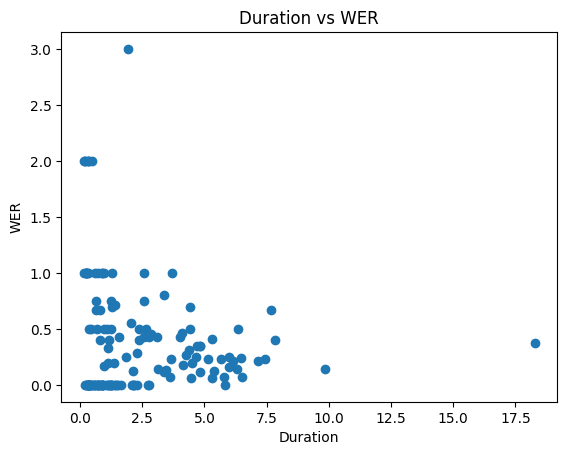

In [ ]:
plt.scatter(df['duration'], df['wer'])
plt.xlabel('Duration')
plt.ylabel('WER')
plt.title('Duration vs WER')
plt.show()

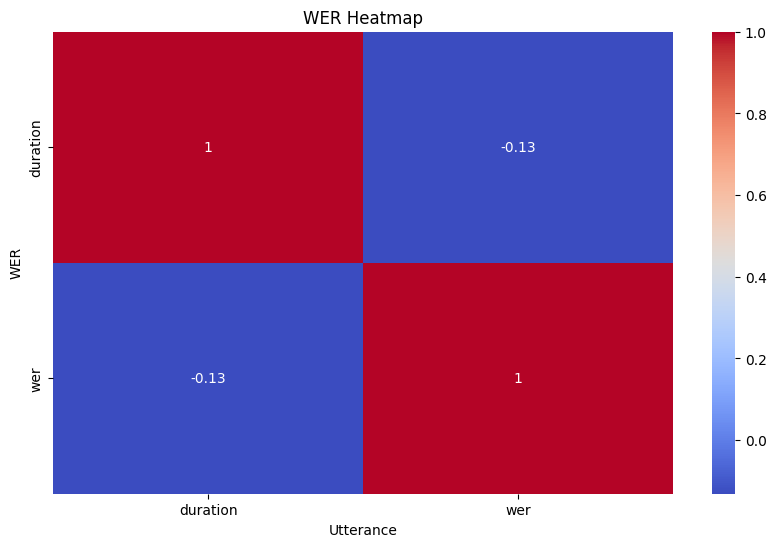

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('WER Heatmap')
plt.xlabel('Utterance')
plt.ylabel('WER')
plt.show()

After looking at the graphs, i can see that are no correlation

## 3. Whisper tokenizer (15pt)

In the next code cell, the tokenizer used by multilingual models is initialized in the variable ``tokenizer``. Without changing the ``tokenizer`` variable, do the following:

1. Print the token index of beginning of sentence and end of sentence special tokens
2. Based on [this dictionary](https://github.com/openai/whisper/blob/90db0de1896c23cbfaf0c58bc2d30665f709f170/whisper/tokenizer.py#L10), print the the token index of two languages: French and German. An example is already given below for English.
3. Given that the supported languages are in ``whisper.tokenizer.LANGUAGES``, find out only using python code if (a) your native tongue is supported (b) the language Kurmanji is supported.

In [ ]:
from whisper import load_model

model = load_model('base', device='cpu', download_root='./')

100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 104MiB/s]


In [ ]:
import whisper.tokenizer as whisper_tokenizer

tokenizer = whisper_tokenizer.get_tokenizer(
    True,  # assume a multilingual model
    num_languages=model.num_languages,
)

In [ ]:
## 1. Print the token index of bos, eos (2.5 pt)
#print(tokenizer.special_tokens)
print("Beginning of sequence/sentence: ", tokenizer.special_tokens['<|startoftranscript|>'])
print("End of sequence/sentence: ", tokenizer.special_tokens['<|endoftext|>'])

Beginning of sequence/sentence:  50258
End of sequence/sentence:  50257


In [ ]:
# This is an example to get the language token for English.
tokenizer.special_tokens.get('<|en|>')

50259

In [ ]:
## 2. print the the token index of French and German (2.5 pt)
french_token = tokenizer.special_tokens.get('<|fr|>')
german_token = tokenizer.special_tokens.get('<|de|>')

print(f"Token index for French: {french_token}")
print(f"Token index for German: {german_token}")

Token index for French: 50265
Token index for German: 50261


In [ ]:
## 3. Find out only using python code if (a) your native tongue is supported (b) the language Kurmanji is supported. (10 pt)
native_tongue = "tr"
kurmanji = "kmr"

# Check if native tongue is supported
native_tongue_supported = native_tongue in whisper_tokenizer.LANGUAGES

# Check if Kurmanji is supported
kurmanji_supported = kurmanji in whisper_tokenizer.LANGUAGES

# Print the results
print(f"Is my native tongue supported? {native_tongue_supported}")
print(f"Is Kurmanji supported? {kurmanji_supported}")

Is my native tongue supported? True
Is Kurmanji supported? False


## 1D convolution vs TDNN (25pt)

As seen in class, Whisper uses two convolutional layers before the Transformer layers.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

n_mels = 80
n_state = 768
conv1 = nn.Conv1d(n_mels, n_state, kernel_size=3)
conv2 = nn.Conv1d(n_state, n_state, kernel_size=3)

In [ ]:
# 1. Create an appropriate input for the above convolutional layer, and apply it
# to the first convolutional layer. The input is a 3-dimensional tensor.
# The first dimenion is a number of sequences, we assume there is only one sequence.
# The second dimenion is the number of filterbank energies per frame.
# The third dimension is the maximum audio length in number of frames.

x = torch.randn(1, n_mels, 3000)

In [ ]:
# 2. Get the output after passing it through the first 2 convolution layers.

# forward pass
x = F.gelu(conv1(x))
x = F.gelu(conv2(x))

# debug statement only, not part of forward pass
x.shape

torch.Size([1, 768, 2996])

In [ ]:
# 3. Adjust the hyperparameters of the two Conv1d layers above to get an output
# of sequence length 1000. Please re-write all code in this cell here. Do not
# modify the code above.

conv1 = nn.Conv1d(n_mels, n_state, kernel_size=3, bias=False, padding=1)
conv2 = nn.Conv1d(n_state, n_state, kernel_size=3, padding=1, stride=3)


x = torch.randn(1, n_mels, 3000)
x = F.gelu(conv1(x))
x = F.gelu(conv2(x))
x.shape

torch.Size([1, 768, 1000])

4. Would your approach to getting the desired sequence length at the output of the two convolutional layers change if we did not apply the non-linearity in the forward pass?

The approach to adjusting the hyperparameters for the convolutional layers to achieve the desired sequence length would remain the same whether or not a non-linearity is applied in the forward pass. This is because the sequence length of the output tensor from a convolutional layer is determined by the layer's hyperparameters (such as kernel size, stride, padding, and dilation), and not by the activation function.

5. Use the Conv1D class instead of the TDNN class in Exercise 4 to create one of the layers of the X-vector network. The details about which layer is given in the code below.

NOTE: Only re-write it. No need to test it (unless you prefer to demonstrate that they are equal).

In [ ]:
# The class is commented. It is only to be used as a reference
# class TDNN(nn.Module):
#     def __init__(
#         self,
#         feat_dim,
#         output_dim,
#         context_len=1,
#     ):
#         super(TDNN, self).__init__()
#         self.linear = nn.Linear(feat_dim*context_len, output_dim)
#         self.context_len = torch.tensor(context_len, requires_grad=False)


#     def forward(self, input):
#         mb, T, D = input.shape
#         padded_input = input.reshape(mb, -1).unfold(1, D*self.context_len, D).contiguous()
#         x = self.linear(padded_input)
#         return x

# Rewrite the line below with Conv1D
# tdnn1 = TDNN(feat_dim=40, output_dim=128, context_len=3)

tdnn1 = nn.Conv1d(in_channels=40, out_channels=128, kernel_size=3)